# Applying XID+CIGALE to Extreme Starbursts
In this notebook, we read in the data files and prepare them for fitting with XID+CIGALE, the SED prior model extension to XID+. Here we focus on sources in [Rowan-Robinson et al. 2018](https://arxiv.org/abs/1704.07783) and claimed to have a star formation rate of $> 10^{3}\mathrm{M_{\odot}yr^{-1}}$

In [1]:

field=['Lockman-SWIRE']
#path_to_SPIRE=['/Volumes/pdh_storage/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/']
path_to_SPIRE=['/mnt/lustre/users/astro/pdh21/Extreme_submm_SB_gals/data/']
#redshift_file=["/Volumes/pdh_storage/dmu_products/dmu24/dmu24_Lockman-SWIRE/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_20180219.fits"]
redshift_file=["/mnt/lustre/users/astro/pdh21/Extreme_submm_SB_gals/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_20180219.fits"]

In [2]:
# Parameters
field = ["Lockman-SWIRE"]
path_to_SPIRE = ["/mnt/lustre/users/astro/pdh21/Extreme_submm_SB_gals/data/"]
redshift_file = [
    "/mnt/lustre/users/astro/pdh21/Extreme_submm_SB_gals/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_20180219.fits"
]


Import required modules

In [3]:
from astropy.io import ascii, fits
from astropy.table import Table
import pylab as plt
%matplotlib inline
from astropy import wcs


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import os


In [4]:
source=[np.int(os.environ['SGE_TASK_ID'])-1]

Set image and catalogue filenames

In [5]:
#Folder containing maps
pswfits=path_to_SPIRE[0]+'{}_SPIRE250_v1.0.fits'.format(field[0])#SPIRE 250 map
pmwfits=path_to_SPIRE[0]+'{}_SPIRE350_v1.0.fits'.format(field[0])#SPIRE 350 map
plwfits=path_to_SPIRE[0]+'{}_SPIRE500_v1.0.fits'.format(field[0])#SPIRE 500 map




#output folder
output_folder='./'

Load in images, noise maps, header info and WCS information

In [6]:
#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data*1.0E3 #convert to mJy
nim250=hdulist[3].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist[1].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist[1].header

im350=hdulist[1].data*1.0E3 #convert to mJy
nim350=hdulist[3].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist[1].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist[1].header 
im500=hdulist[1].data*1.0E3 #convert to mJy
nim500=hdulist[3].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist[1].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

XID+ uses Multi Order Coverage (MOC) maps for cutting down maps and catalogues so they cover the same area. It can also take in MOCs as selection functions to carry out additional cuts. Lets use the python module [pymoc](http://pymoc.readthedocs.io/en/latest/) to create a MOC, centered on a specific position we are interested in. We will use a HEALPix order of 15 (the resolution: higher order means higher resolution)

Read in the source we are interested in from Rowan-Robinsons's catalogue.

In [7]:
#ysb=Table.read('../../../data/MRRfiles/fromPaper.txt', format='ascii')
esb=Table.read('../../../data/MRR2018_tables/{}_sources.csv'.format(field[0]),format='ascii')

In [8]:
esb

RA,Dec,i,S 24 (μJy),S 250 (mJy),S 350 (mJy),S 500 (mJy),Z phot,Type,Chi,n bands,Z subm,Z comb,M * log(M sol.),SFR log(M sol. yr−1),field
float64,float64,str9,float64,float64,float64,float64,float64,str9,float64,int64,float64,float64,float64,float64,str13
159.03456,58.44533,21.37,1127.8,131.6,84.2,42.2,1.44,Scd,4.8,4,1.16,1.19,11.62,3.89,Lockman-SWIRE
160.50839,58.67179,23.49,904.6,95.7,79.5,60.5,3.81,Sab,4.1,6,2.86,3.07,12.02,3.99,Lockman-SWIRE
160.51041,58.67371,--,--,--,--,--,1.08,--,--,--,--,--,--,3.05,Lockman-SWIRE
161.98271,58.07477,22.1,264.4,44.2,45.3,33.6,4.13,sb,25.4,6,3.15,3.68,11.87,3.76,Lockman-SWIRE
162.33324,58.10657,22.61,516.4,56.9,52.9,59.6,2.8,Scd,6.1,8,4.09,2.89,11.69,3.72,Lockman-SWIRE
160.9194,57.91475,22.32,682.3,116.5,102.0,65.4,3.06,Sab,20.5,6,2.56,2.8,12.5,4.12,Lockman-SWIRE
162.38754,57.70547,g = 24.13,519.3,65.7,65.0,56.3,3.37,Scd,1.6,3,3.47,3.37,12.15,3.74,Lockman-SWIRE
162.46065,58.11701,21.96,252.5,--,28.4,41.4,4.06,sb (QSO?),7.9,6,4.81,4.13,11.97,3.98,Lockman-SWIRE
164.52054,58.30782,23.4,306.9,81.9,92.1,58.2,4.18,Sab,0.03,3,2.16,3.07,12.4,3.99,Lockman-SWIRE


In [9]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import os

c = SkyCoord(ra=[esb['RA'][source[0]]]*u.degree, dec=[esb['Dec'][source[0]]]*u.degree)

import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,100,15)

In [10]:
c.dec.deg[0]

58.03157

Load in catalogue you want to fit (and make any cuts). Here we use HELP's VO database and directly call it using PyVO

In [11]:
import pyvo as vo
service = vo.dal.TAPService("https://herschel-vos.phys.sussex.ac.uk/__system__/tap/run/tap")

In [12]:
resultset = service.search("SELECT TOP 10000 * FROM herschelhelp.main WHERE 1=CONTAINS(POINT('ICRS', ra, dec),CIRCLE('ICRS',"+str(c.ra.deg[0])+", "+str(c.dec.deg[0])+", 0.028 ))")

In [13]:
masterlist=resultset.table

In [14]:
masterlist

field,help_id,ra,dec,hp_idx,ebv,redshift,zspec,zspec_qual,zspec_association_flag,stellarity,stellarity_origin,f_90prime_g,ferr_90prime_g,f_ap_90prime_g,ferr_ap_90prime_g,m_90prime_g,merr_90prime_g,m_ap_90prime_g,merr_ap_90prime_g,flag_90prime_g,f_90prime_r,ferr_90prime_r,f_ap_90prime_r,ferr_ap_90prime_r,m_90prime_r,merr_90prime_r,m_ap_90prime_r,merr_ap_90prime_r,flag_90prime_r,f_90prime_z,ferr_90prime_z,f_ap_90prime_z,ferr_ap_90prime_z,m_90prime_z,merr_90prime_z,m_ap_90prime_z,merr_ap_90prime_z,flag_90prime_z,f_acs_f435w,ferr_acs_f435w,f_ap_acs_f435w,ferr_ap_acs_f435w,m_acs_f435w,merr_acs_f435w,m_ap_acs_f435w,merr_ap_acs_f435w,flag_acs_f435w,f_acs_f606w,ferr_acs_f606w,f_ap_acs_f606w,ferr_ap_acs_f606w,m_acs_f606w,merr_acs_f606w,m_ap_acs_f606w,merr_ap_acs_f606w,flag_acs_f606w,f_acs_f775w,ferr_acs_f775w,f_ap_acs_f775w,ferr_ap_acs_f775w,m_acs_f775w,merr_acs_f775w,m_ap_acs_f775w,merr_ap_acs_f775w,flag_acs_f775w,f_acs_f814w,ferr_acs_f814w,f_ap_acs_f814w,ferr_ap_acs_f814w,m_acs_f814w,merr_acs_f814w,m_ap_acs_f814w,merr_ap_acs_f814w,flag_acs_f814w,f_acs_f850lp,ferr_acs_f850lp,f_ap_acs_f850lp,ferr_ap_acs_f850lp,m_acs_f850lp,merr_acs_f850lp,m_ap_acs_f850lp,merr_ap_acs_f850lp,flag_acs_f850lp,f_bessell_b,ferr_bessell_b,f_ap_bessell_b,ferr_ap_bessell_b,m_bessell_b,merr_bessell_b,m_ap_bessell_b,merr_ap_bessell_b,flag_bessell_b,f_bessell_i,ferr_bessell_i,f_ap_bessell_i,ferr_ap_bessell_i,m_bessell_i,merr_bessell_i,m_ap_bessell_i,merr_ap_bessell_i,flag_bessell_i,f_bessell_r,ferr_bessell_r,f_ap_bessell_r,ferr_ap_bessell_r,m_bessell_r,merr_bessell_r,m_ap_bessell_r,merr_ap_bessell_r,flag_bessell_r,f_bessell_u,ferr_bessell_u,f_ap_bessell_u,ferr_ap_bessell_u,m_bessell_u,merr_bessell_u,m_ap_bessell_u,merr_ap_bessell_u,flag_bessell_u,f_bessell_v,ferr_bessell_v,f_ap_bessell_v,ferr_ap_bessell_v,m_bessell_v,merr_bessell_v,m_ap_bessell_v,merr_ap_bessell_v,flag_bessell_v,f_cfht12k_b,ferr_cfht12k_b,f_ap_cfht12k_b,ferr_ap_cfht12k_b,m_cfht12k_b,merr_cfht12k_b,m_ap_cfht12k_b,merr_ap_cfht12k_b,flag_cfht12k_b,f_cfht12k_i,ferr_cfht12k_i,f_ap_cfht12k_i,ferr_ap_cfht12k_i,m_cfht12k_i,merr_cfht12k_i,m_ap_cfht12k_i,merr_ap_cfht12k_i,flag_cfht12k_i,f_cfht12k_r,ferr_cfht12k_r,f_ap_cfht12k_r,ferr_ap_cfht12k_r,m_cfht12k_r,merr_cfht12k_r,m_ap_cfht12k_r,merr_ap_cfht12k_r,flag_cfht12k_r,f_decam_g,ferr_decam_g,f_ap_decam_g,ferr_ap_decam_g,m_decam_g,merr_decam_g,m_ap_decam_g,merr_ap_decam_g,flag_decam_g,f_decam_i,ferr_decam_i,f_ap_decam_i,ferr_ap_decam_i,m_decam_i,merr_decam_i,m_ap_decam_i,merr_ap_decam_i,flag_decam_i,f_decam_r,ferr_decam_r,f_ap_decam_r,ferr_ap_decam_r,m_decam_r,merr_decam_r,m_ap_decam_r,merr_ap_decam_r,flag_decam_r,f_decam_y,ferr_decam_y,f_ap_decam_y,ferr_ap_decam_y,m_decam_y,merr_decam_y,m_ap_decam_y,merr_ap_decam_y,flag_decam_y,f_decam_z,ferr_decam_z,f_ap_decam_z,ferr_ap_decam_z,m_decam_z,merr_decam_z,m_ap_decam_z,merr_ap_decam_z,flag_decam_z,f_galex_fuv,ferr_galex_fuv,f_ap_galex_fuv,ferr_ap_galex_fuv,m_galex_fuv,merr_galex_fuv,m_ap_galex_fuv,merr_ap_galex_fuv,flag_galex_fuv,f_galex_nuv,ferr_galex_nuv,f_ap_galex_nuv,ferr_ap_galex_nuv,m_galex_nuv,merr_galex_nuv,m_ap_galex_nuv,merr_ap_galex_nuv,flag_galex_nuv,f_gpc1_g,ferr_gpc1_g,f_ap_gpc1_g,ferr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,flag_gpc1_g,f_gpc1_i,ferr_gpc1_i,f_ap_gpc1_i,ferr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,flag_gpc1_i,f_gpc1_r,ferr_gpc1_r,f_ap_gpc1_r,ferr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,flag_gpc1_r,f_gpc1_y,ferr_gpc1_y,f_ap_gpc1_y,ferr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,flag_gpc1_y,f_gpc1_z,ferr_gpc1_z,f_ap_gpc1_z,ferr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,flag_gpc1_z,f_hawki_k,ferr_hawki_k,f_ap_hawki_k,ferr_ap_hawki_k,m_hawki_k,merr_hawki_k,m_ap_hawki_k,merr_ap_hawki_k,flag_hawki_k,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,flag_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr

## Filter table
We will only use objects that are not stars (i.e. have `flag_gaia` = 3)

In [15]:
prior_list=masterlist[(masterlist['flag_gaia']!=3) & (masterlist['flag_optnir_det']>=3)]

### Check original source in prior list, if not then add

In [16]:
in_prior=prior_list['help_id']==masterlist[np.argmin(c.separation(SkyCoord(masterlist['ra'],masterlist['dec'])).arcsec)]['help_id']
if in_prior.sum()==1:
    print('in prior list')
else:
    from astropy.table import vstack,hstack
    prior_list=vstack((prior_list,masterlist[masterlist['help_id']==masterlist[np.argmin(c.separation(SkyCoord(masterlist['ra'],masterlist['dec'])).arcsec)]['help_id']]))

in prior list


## Get Redshift and Uncertianty


Ken Duncan defines a median and a hierarchical bayes combination redshift. We need uncertianty so lets match via `help_id`

In [17]:
photoz=Table.read(redshift_file[0])

In [18]:
#help_id=np.empty((len(photoz)),dtype=np.dtype('U27'))
for i in range(0,len(photoz)):
    photoz['help_id'][i]=str(photoz['help_id'][i].strip()).encode('utf-8')
#photoz['help_id']=help_id

In [19]:
from astropy.table import Column, MaskedColumn
prior_list['redshift']=MaskedColumn(np.full((len(prior_list)),fill_value=0.1),mask=[False]*len(prior_list))
prior_list.add_column(MaskedColumn(np.full((len(prior_list)),fill_value=2.0),mask=[False]*len(prior_list),name='redshift_unc'))

In [20]:
photoz

help_id,help_id_old,photoz_ra,photoz_dec,id,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,za_hb,za_eazy,zm_eazy,zpeak_eazy,chi_r_eazy,l68_eazy,u68_eazy,nfilt_eazy,za_atlas,zm_atlas,zpeak_atlas,chi_r_atlas,l68_atlas,u68_atlas,nfilt_atlas,za_cosmos,zm_cosmos,zpeak_cosmos,chi_r_cosmos,l68_cosmos,u68_cosmos,nfilt_cosmos,chi_r_stellar,stellar_type
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes27,bytes27,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,bytes6
HELP_J105455.339+572548.213,HELP_J105455.339+572548.213,163.7305786077025,57.43005918785325,127,0.2198,0.1874,0.2494,0.766,-99.0,-99.0,-99.0,-99.0,0.22714963592146123,4.153,4.158,4.1576,24.2823375,4.107,4.209,5,4.215,4.067,4.0672,22.9347525,3.763,4.255,5,4.107,3.898,3.8981,21.4151075,3.703,4.113,5,110.18145,k3i
HELP_J105331.913+573410.713,HELP_J105331.913+573410.713,163.3829720687025,57.56964253985325,800,0.0801,0.0284,0.1386,0.783,-99.0,-99.0,-99.0,-99.0,0.07239686804834258,2.751,2.503,2.7178,0.1155692,2.558,2.817,5,2.808,2.602,2.6199,0.2732135,2.413,2.817,5,2.023,2.168,2.1849,0.088402725,2.006,2.356,5,1.44887175,g0v
HELP_J105527.800+575424.407,HELP_J105527.800+575424.407,163.86583515770252,57.90677978385325,2049,0.9878,0.8114,1.2207,0.793,-99.0,-99.0,-99.0,-99.0,0.8553518417411408,3.668,3.57,3.6845,40.3132,3.606,3.742,5,3.571,3.566,3.5667,38.761975,3.489,3.643,5,2.097,2.197,2.0877,41.809975,2.038,2.158,5,108.3082,b1i
HELP_J104646.624+601224.028,HELP_J104646.624+601224.028,161.6942666127025,60.20667451885325,3148,0.0696,0.0253,0.115,0.781,-99.0,-99.0,-99.0,-99.0,0.05329479684704154,2.995,2.973,2.9736,1.84914925,2.871,3.074,5,2.565,2.596,2.6692,0.050988875,2.503,2.822,5,2.554,2.624,2.788,0.216888075,2.334,3.199,5,4.07228,k5v
HELP_J105034.405+593434.787,HELP_J105034.405+593434.787,162.6433552597025,59.57632970685325,3151,0.7712,0.7475,0.7952,0.684,-99.0,-99.0,-99.0,-99.0,0.7685256024616454,3.091,3.101,3.1007,2.78713,3.064,3.137,5,3.116,3.121,3.1211,24.79483,3.087,3.157,5,2.181,2.219,2.1895,30.6239,2.146,2.237,5,57.492025,f0i
HELP_J104700.697+603101.851,HELP_J104700.697+603101.851,161.75290509070248,60.51718077685325,3152,0.3288,0.2457,0.3875,0.672,0.1776,0.125,0.2345,0.117,0.3186207796877177,0.307,1.738,2.3391,0.3700905,0.313,2.412,5,2.005,2.246,2.1302,0.34619775,1.975,2.36,5,0.343,0.582,0.3368,0.230738975,0.319,0.367,5,10.98019,k4v
HELP_J104700.735+601459.749,HELP_J104700.735+601459.749,161.7530627767025,60.24993040785325,4922,0.2286,0.001,0.583,0.798,-99.0,-99.0,-99.0,-99.0,0.14888615644345088,2.491,2.091,2.4759,0.00147433525,0.217,2.729,5,2.796,2.536,2.5509,0.071763075,2.108,2.881,5,2.023,2.041,2.1511,0.087912975,1.958,2.304,5,3.068795,wk0iii
HELP_J104433.838+602158.646,HELP_J104433.838+602158.646,161.1409924377025,60.36629051285325,7675,1.9915,1.5641,2.4596,0.674,0.7688,0.6858,0.8498,0.063,1.942862458604582,0.013,0.013,0.0134,19.00683,0.005,0.022,5,2.418,2.461,2.4612,34.892025,2.352,2.582,5,2.449,2.462,2.4615,39.02275,2.39,2.535,5,12.4638525,o5v


In [21]:
ii=0
for i in range(0,len(prior_list)):
    ind=photoz['help_id'] == prior_list['help_id'][i]
    try:
        
        prior_list['redshift'][i]=photoz['z1_median'][ind]
        prior_list['redshift_unc'][i]=np.max(np.array([np.abs(photoz['z1_median'][ind]-photoz['z1_min'][ind]),np.abs(photoz['z1_max'][ind]-photoz['z1_median'][ind])]))
        
        #prior_list['redshift_unc'].mask[i]=False
        #prior_list['redshift'].mask[i]=False

    except ValueError:
        None

In [22]:
prior_list['redshift']

0.8729
1.5407
2.0193
1.6632
0.4771
0.1298
1.7611
2.1971
0.0877
0.6749
0.6389


In [23]:
prior_list[prior_list['redshift'].mask == False]

field,help_id,ra,dec,hp_idx,ebv,redshift,zspec,zspec_qual,zspec_association_flag,stellarity,stellarity_origin,f_90prime_g,ferr_90prime_g,f_ap_90prime_g,ferr_ap_90prime_g,m_90prime_g,merr_90prime_g,m_ap_90prime_g,merr_ap_90prime_g,flag_90prime_g,f_90prime_r,ferr_90prime_r,f_ap_90prime_r,ferr_ap_90prime_r,m_90prime_r,merr_90prime_r,m_ap_90prime_r,merr_ap_90prime_r,flag_90prime_r,f_90prime_z,ferr_90prime_z,f_ap_90prime_z,ferr_ap_90prime_z,m_90prime_z,merr_90prime_z,m_ap_90prime_z,merr_ap_90prime_z,flag_90prime_z,f_acs_f435w,ferr_acs_f435w,f_ap_acs_f435w,ferr_ap_acs_f435w,m_acs_f435w,merr_acs_f435w,m_ap_acs_f435w,merr_ap_acs_f435w,flag_acs_f435w,f_acs_f606w,ferr_acs_f606w,f_ap_acs_f606w,ferr_ap_acs_f606w,m_acs_f606w,merr_acs_f606w,m_ap_acs_f606w,merr_ap_acs_f606w,flag_acs_f606w,f_acs_f775w,ferr_acs_f775w,f_ap_acs_f775w,ferr_ap_acs_f775w,m_acs_f775w,merr_acs_f775w,m_ap_acs_f775w,merr_ap_acs_f775w,flag_acs_f775w,f_acs_f814w,ferr_acs_f814w,f_ap_acs_f814w,ferr_ap_acs_f814w,m_acs_f814w,merr_acs_f814w,m_ap_acs_f814w,merr_ap_acs_f814w,flag_acs_f814w,f_acs_f850lp,ferr_acs_f850lp,f_ap_acs_f850lp,ferr_ap_acs_f850lp,m_acs_f850lp,merr_acs_f850lp,m_ap_acs_f850lp,merr_ap_acs_f850lp,flag_acs_f850lp,f_bessell_b,ferr_bessell_b,f_ap_bessell_b,ferr_ap_bessell_b,m_bessell_b,merr_bessell_b,m_ap_bessell_b,merr_ap_bessell_b,flag_bessell_b,f_bessell_i,ferr_bessell_i,f_ap_bessell_i,ferr_ap_bessell_i,m_bessell_i,merr_bessell_i,m_ap_bessell_i,merr_ap_bessell_i,flag_bessell_i,f_bessell_r,ferr_bessell_r,f_ap_bessell_r,ferr_ap_bessell_r,m_bessell_r,merr_bessell_r,m_ap_bessell_r,merr_ap_bessell_r,flag_bessell_r,f_bessell_u,ferr_bessell_u,f_ap_bessell_u,ferr_ap_bessell_u,m_bessell_u,merr_bessell_u,m_ap_bessell_u,merr_ap_bessell_u,flag_bessell_u,f_bessell_v,ferr_bessell_v,f_ap_bessell_v,ferr_ap_bessell_v,m_bessell_v,merr_bessell_v,m_ap_bessell_v,merr_ap_bessell_v,flag_bessell_v,f_cfht12k_b,ferr_cfht12k_b,f_ap_cfht12k_b,ferr_ap_cfht12k_b,m_cfht12k_b,merr_cfht12k_b,m_ap_cfht12k_b,merr_ap_cfht12k_b,flag_cfht12k_b,f_cfht12k_i,ferr_cfht12k_i,f_ap_cfht12k_i,ferr_ap_cfht12k_i,m_cfht12k_i,merr_cfht12k_i,m_ap_cfht12k_i,merr_ap_cfht12k_i,flag_cfht12k_i,f_cfht12k_r,ferr_cfht12k_r,f_ap_cfht12k_r,ferr_ap_cfht12k_r,m_cfht12k_r,merr_cfht12k_r,m_ap_cfht12k_r,merr_ap_cfht12k_r,flag_cfht12k_r,f_decam_g,ferr_decam_g,f_ap_decam_g,ferr_ap_decam_g,m_decam_g,merr_decam_g,m_ap_decam_g,merr_ap_decam_g,flag_decam_g,f_decam_i,ferr_decam_i,f_ap_decam_i,ferr_ap_decam_i,m_decam_i,merr_decam_i,m_ap_decam_i,merr_ap_decam_i,flag_decam_i,f_decam_r,ferr_decam_r,f_ap_decam_r,ferr_ap_decam_r,m_decam_r,merr_decam_r,m_ap_decam_r,merr_ap_decam_r,flag_decam_r,f_decam_y,ferr_decam_y,f_ap_decam_y,ferr_ap_decam_y,m_decam_y,merr_decam_y,m_ap_decam_y,merr_ap_decam_y,flag_decam_y,f_decam_z,ferr_decam_z,f_ap_decam_z,ferr_ap_decam_z,m_decam_z,merr_decam_z,m_ap_decam_z,merr_ap_decam_z,flag_decam_z,f_galex_fuv,ferr_galex_fuv,f_ap_galex_fuv,ferr_ap_galex_fuv,m_galex_fuv,merr_galex_fuv,m_ap_galex_fuv,merr_ap_galex_fuv,flag_galex_fuv,f_galex_nuv,ferr_galex_nuv,f_ap_galex_nuv,ferr_ap_galex_nuv,m_galex_nuv,merr_galex_nuv,m_ap_galex_nuv,merr_ap_galex_nuv,flag_galex_nuv,f_gpc1_g,ferr_gpc1_g,f_ap_gpc1_g,ferr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,flag_gpc1_g,f_gpc1_i,ferr_gpc1_i,f_ap_gpc1_i,ferr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,flag_gpc1_i,f_gpc1_r,ferr_gpc1_r,f_ap_gpc1_r,ferr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,flag_gpc1_r,f_gpc1_y,ferr_gpc1_y,f_ap_gpc1_y,ferr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,flag_gpc1_y,f_gpc1_z,ferr_gpc1_z,f_ap_gpc1_z,ferr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,flag_gpc1_z,f_hawki_k,ferr_hawki_k,f_ap_hawki_k,ferr_ap_hawki_k,m_hawki_k,merr_hawki_k,m_ap_hawki_k,merr_ap_hawki_k,flag_hawki_k,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,flag_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr

In [24]:
dist_matrix=np.zeros((len(prior_list),len(prior_list)))
from astropy.coordinates import SkyCoord
from astropy import units as u
for i in range(0,len(prior_list)):
    for j in range(0,len(prior_list)):
        if i>j:
            coord1 = SkyCoord(ra=prior_list['ra'][i]*u.deg,dec=prior_list['dec'][i]*u.deg,frame='icrs')

            coord2=SkyCoord(ra=prior_list['ra'][j]*u.deg,dec=prior_list['dec'][j]*u.deg)
            dist_matrix[i,j] = coord1.separation(coord2).value

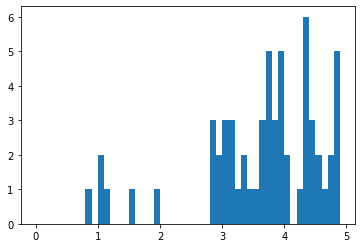

In [25]:
plt.hist(np.tril(dist_matrix).flatten()*3600.0,bins=np.arange(0.00001,5,0.1));

In [26]:
ind=(np.tril(dist_matrix)<1.0/3600.0) & (np.tril(dist_matrix)>0)
xx,yy=np.meshgrid(np.arange(0,len(prior_list)),np.arange(0,len(prior_list)))
yy[ind]

array([239])

In [27]:
prior_list[yy[ind]]

field,help_id,ra,dec,hp_idx,ebv,redshift,zspec,zspec_qual,zspec_association_flag,stellarity,stellarity_origin,f_90prime_g,ferr_90prime_g,f_ap_90prime_g,ferr_ap_90prime_g,m_90prime_g,merr_90prime_g,m_ap_90prime_g,merr_ap_90prime_g,flag_90prime_g,f_90prime_r,ferr_90prime_r,f_ap_90prime_r,ferr_ap_90prime_r,m_90prime_r,merr_90prime_r,m_ap_90prime_r,merr_ap_90prime_r,flag_90prime_r,f_90prime_z,ferr_90prime_z,f_ap_90prime_z,ferr_ap_90prime_z,m_90prime_z,merr_90prime_z,m_ap_90prime_z,merr_ap_90prime_z,flag_90prime_z,f_acs_f435w,ferr_acs_f435w,f_ap_acs_f435w,ferr_ap_acs_f435w,m_acs_f435w,merr_acs_f435w,m_ap_acs_f435w,merr_ap_acs_f435w,flag_acs_f435w,f_acs_f606w,ferr_acs_f606w,f_ap_acs_f606w,ferr_ap_acs_f606w,m_acs_f606w,merr_acs_f606w,m_ap_acs_f606w,merr_ap_acs_f606w,flag_acs_f606w,f_acs_f775w,ferr_acs_f775w,f_ap_acs_f775w,ferr_ap_acs_f775w,m_acs_f775w,merr_acs_f775w,m_ap_acs_f775w,merr_ap_acs_f775w,flag_acs_f775w,f_acs_f814w,ferr_acs_f814w,f_ap_acs_f814w,ferr_ap_acs_f814w,m_acs_f814w,merr_acs_f814w,m_ap_acs_f814w,merr_ap_acs_f814w,flag_acs_f814w,f_acs_f850lp,ferr_acs_f850lp,f_ap_acs_f850lp,ferr_ap_acs_f850lp,m_acs_f850lp,merr_acs_f850lp,m_ap_acs_f850lp,merr_ap_acs_f850lp,flag_acs_f850lp,f_bessell_b,ferr_bessell_b,f_ap_bessell_b,ferr_ap_bessell_b,m_bessell_b,merr_bessell_b,m_ap_bessell_b,merr_ap_bessell_b,flag_bessell_b,f_bessell_i,ferr_bessell_i,f_ap_bessell_i,ferr_ap_bessell_i,m_bessell_i,merr_bessell_i,m_ap_bessell_i,merr_ap_bessell_i,flag_bessell_i,f_bessell_r,ferr_bessell_r,f_ap_bessell_r,ferr_ap_bessell_r,m_bessell_r,merr_bessell_r,m_ap_bessell_r,merr_ap_bessell_r,flag_bessell_r,f_bessell_u,ferr_bessell_u,f_ap_bessell_u,ferr_ap_bessell_u,m_bessell_u,merr_bessell_u,m_ap_bessell_u,merr_ap_bessell_u,flag_bessell_u,f_bessell_v,ferr_bessell_v,f_ap_bessell_v,ferr_ap_bessell_v,m_bessell_v,merr_bessell_v,m_ap_bessell_v,merr_ap_bessell_v,flag_bessell_v,f_cfht12k_b,ferr_cfht12k_b,f_ap_cfht12k_b,ferr_ap_cfht12k_b,m_cfht12k_b,merr_cfht12k_b,m_ap_cfht12k_b,merr_ap_cfht12k_b,flag_cfht12k_b,f_cfht12k_i,ferr_cfht12k_i,f_ap_cfht12k_i,ferr_ap_cfht12k_i,m_cfht12k_i,merr_cfht12k_i,m_ap_cfht12k_i,merr_ap_cfht12k_i,flag_cfht12k_i,f_cfht12k_r,ferr_cfht12k_r,f_ap_cfht12k_r,ferr_ap_cfht12k_r,m_cfht12k_r,merr_cfht12k_r,m_ap_cfht12k_r,merr_ap_cfht12k_r,flag_cfht12k_r,f_decam_g,ferr_decam_g,f_ap_decam_g,ferr_ap_decam_g,m_decam_g,merr_decam_g,m_ap_decam_g,merr_ap_decam_g,flag_decam_g,f_decam_i,ferr_decam_i,f_ap_decam_i,ferr_ap_decam_i,m_decam_i,merr_decam_i,m_ap_decam_i,merr_ap_decam_i,flag_decam_i,f_decam_r,ferr_decam_r,f_ap_decam_r,ferr_ap_decam_r,m_decam_r,merr_decam_r,m_ap_decam_r,merr_ap_decam_r,flag_decam_r,f_decam_y,ferr_decam_y,f_ap_decam_y,ferr_ap_decam_y,m_decam_y,merr_decam_y,m_ap_decam_y,merr_ap_decam_y,flag_decam_y,f_decam_z,ferr_decam_z,f_ap_decam_z,ferr_ap_decam_z,m_decam_z,merr_decam_z,m_ap_decam_z,merr_ap_decam_z,flag_decam_z,f_galex_fuv,ferr_galex_fuv,f_ap_galex_fuv,ferr_ap_galex_fuv,m_galex_fuv,merr_galex_fuv,m_ap_galex_fuv,merr_ap_galex_fuv,flag_galex_fuv,f_galex_nuv,ferr_galex_nuv,f_ap_galex_nuv,ferr_ap_galex_nuv,m_galex_nuv,merr_galex_nuv,m_ap_galex_nuv,merr_ap_galex_nuv,flag_galex_nuv,f_gpc1_g,ferr_gpc1_g,f_ap_gpc1_g,ferr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,flag_gpc1_g,f_gpc1_i,ferr_gpc1_i,f_ap_gpc1_i,ferr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,flag_gpc1_i,f_gpc1_r,ferr_gpc1_r,f_ap_gpc1_r,ferr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,flag_gpc1_r,f_gpc1_y,ferr_gpc1_y,f_ap_gpc1_y,ferr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,flag_gpc1_y,f_gpc1_z,ferr_gpc1_z,f_ap_gpc1_z,ferr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,flag_gpc1_z,f_hawki_k,ferr_hawki_k,f_ap_hawki_k,ferr_ap_hawki_k,m_hawki_k,merr_hawki_k,m_ap_hawki_k,merr_ap_hawki_k,flag_hawki_k,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,flag_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr

In [28]:
prior_list['redshift'].mask[yy[ind]]=True

In [29]:

prior_list=prior_list[prior_list['redshift'].mask == False]

In [30]:
prior_list

field,help_id,ra,dec,hp_idx,ebv,redshift,zspec,zspec_qual,zspec_association_flag,stellarity,stellarity_origin,f_90prime_g,ferr_90prime_g,f_ap_90prime_g,ferr_ap_90prime_g,m_90prime_g,merr_90prime_g,m_ap_90prime_g,merr_ap_90prime_g,flag_90prime_g,f_90prime_r,ferr_90prime_r,f_ap_90prime_r,ferr_ap_90prime_r,m_90prime_r,merr_90prime_r,m_ap_90prime_r,merr_ap_90prime_r,flag_90prime_r,f_90prime_z,ferr_90prime_z,f_ap_90prime_z,ferr_ap_90prime_z,m_90prime_z,merr_90prime_z,m_ap_90prime_z,merr_ap_90prime_z,flag_90prime_z,f_acs_f435w,ferr_acs_f435w,f_ap_acs_f435w,ferr_ap_acs_f435w,m_acs_f435w,merr_acs_f435w,m_ap_acs_f435w,merr_ap_acs_f435w,flag_acs_f435w,f_acs_f606w,ferr_acs_f606w,f_ap_acs_f606w,ferr_ap_acs_f606w,m_acs_f606w,merr_acs_f606w,m_ap_acs_f606w,merr_ap_acs_f606w,flag_acs_f606w,f_acs_f775w,ferr_acs_f775w,f_ap_acs_f775w,ferr_ap_acs_f775w,m_acs_f775w,merr_acs_f775w,m_ap_acs_f775w,merr_ap_acs_f775w,flag_acs_f775w,f_acs_f814w,ferr_acs_f814w,f_ap_acs_f814w,ferr_ap_acs_f814w,m_acs_f814w,merr_acs_f814w,m_ap_acs_f814w,merr_ap_acs_f814w,flag_acs_f814w,f_acs_f850lp,ferr_acs_f850lp,f_ap_acs_f850lp,ferr_ap_acs_f850lp,m_acs_f850lp,merr_acs_f850lp,m_ap_acs_f850lp,merr_ap_acs_f850lp,flag_acs_f850lp,f_bessell_b,ferr_bessell_b,f_ap_bessell_b,ferr_ap_bessell_b,m_bessell_b,merr_bessell_b,m_ap_bessell_b,merr_ap_bessell_b,flag_bessell_b,f_bessell_i,ferr_bessell_i,f_ap_bessell_i,ferr_ap_bessell_i,m_bessell_i,merr_bessell_i,m_ap_bessell_i,merr_ap_bessell_i,flag_bessell_i,f_bessell_r,ferr_bessell_r,f_ap_bessell_r,ferr_ap_bessell_r,m_bessell_r,merr_bessell_r,m_ap_bessell_r,merr_ap_bessell_r,flag_bessell_r,f_bessell_u,ferr_bessell_u,f_ap_bessell_u,ferr_ap_bessell_u,m_bessell_u,merr_bessell_u,m_ap_bessell_u,merr_ap_bessell_u,flag_bessell_u,f_bessell_v,ferr_bessell_v,f_ap_bessell_v,ferr_ap_bessell_v,m_bessell_v,merr_bessell_v,m_ap_bessell_v,merr_ap_bessell_v,flag_bessell_v,f_cfht12k_b,ferr_cfht12k_b,f_ap_cfht12k_b,ferr_ap_cfht12k_b,m_cfht12k_b,merr_cfht12k_b,m_ap_cfht12k_b,merr_ap_cfht12k_b,flag_cfht12k_b,f_cfht12k_i,ferr_cfht12k_i,f_ap_cfht12k_i,ferr_ap_cfht12k_i,m_cfht12k_i,merr_cfht12k_i,m_ap_cfht12k_i,merr_ap_cfht12k_i,flag_cfht12k_i,f_cfht12k_r,ferr_cfht12k_r,f_ap_cfht12k_r,ferr_ap_cfht12k_r,m_cfht12k_r,merr_cfht12k_r,m_ap_cfht12k_r,merr_ap_cfht12k_r,flag_cfht12k_r,f_decam_g,ferr_decam_g,f_ap_decam_g,ferr_ap_decam_g,m_decam_g,merr_decam_g,m_ap_decam_g,merr_ap_decam_g,flag_decam_g,f_decam_i,ferr_decam_i,f_ap_decam_i,ferr_ap_decam_i,m_decam_i,merr_decam_i,m_ap_decam_i,merr_ap_decam_i,flag_decam_i,f_decam_r,ferr_decam_r,f_ap_decam_r,ferr_ap_decam_r,m_decam_r,merr_decam_r,m_ap_decam_r,merr_ap_decam_r,flag_decam_r,f_decam_y,ferr_decam_y,f_ap_decam_y,ferr_ap_decam_y,m_decam_y,merr_decam_y,m_ap_decam_y,merr_ap_decam_y,flag_decam_y,f_decam_z,ferr_decam_z,f_ap_decam_z,ferr_ap_decam_z,m_decam_z,merr_decam_z,m_ap_decam_z,merr_ap_decam_z,flag_decam_z,f_galex_fuv,ferr_galex_fuv,f_ap_galex_fuv,ferr_ap_galex_fuv,m_galex_fuv,merr_galex_fuv,m_ap_galex_fuv,merr_ap_galex_fuv,flag_galex_fuv,f_galex_nuv,ferr_galex_nuv,f_ap_galex_nuv,ferr_ap_galex_nuv,m_galex_nuv,merr_galex_nuv,m_ap_galex_nuv,merr_ap_galex_nuv,flag_galex_nuv,f_gpc1_g,ferr_gpc1_g,f_ap_gpc1_g,ferr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,flag_gpc1_g,f_gpc1_i,ferr_gpc1_i,f_ap_gpc1_i,ferr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,flag_gpc1_i,f_gpc1_r,ferr_gpc1_r,f_ap_gpc1_r,ferr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,flag_gpc1_r,f_gpc1_y,ferr_gpc1_y,f_ap_gpc1_y,ferr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,flag_gpc1_y,f_gpc1_z,ferr_gpc1_z,f_ap_gpc1_z,ferr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,flag_gpc1_z,f_hawki_k,ferr_hawki_k,f_ap_hawki_k,ferr_ap_hawki_k,m_hawki_k,merr_hawki_k,m_ap_hawki_k,merr_ap_hawki_k,flag_hawki_k,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,flag_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr

XID+ is built around two python classes. A prior and posterior class. There should be a prior class for each map being fitted. It is initiated with a map, noise map, primary header and map header and can be set with a MOC. It also requires an input prior catalogue and point spread function.


In [31]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(prior_list['ra'],prior_list['dec'],'photoz',ID=prior_list['help_id'])
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=moc)
prior350.prior_cat(prior_list['ra'],prior_list['dec'],'photoz',ID=prior_list['help_id'])
prior350.prior_bkg(-5.0,5)
#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=moc)
prior500.prior_cat(prior_list['ra'],prior_list['dec'],'photoz',ID=prior_list['help_id'])
prior500.prior_bkg(-5.0,5)

Set PSF. For SPIRE, the PSF can be assumed to be Gaussian with a FWHM of 18.15, 25.15, 36.3 '' for 250, 350 and 500 $\mathrm{\mu m}$ respectively. Lets use the astropy module to construct a Gaussian PSF and assign it to the three XID+ prior classes.

In [32]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

#### Add MIPS 24 data

mipsfits='/Volumes/pdh_storage/dmu_products/dmu26/data/Lockman-SWIRE/MIPS/wp4_lockman-swire_mips24_map_v1.0.fits.gz'
#-----24-------------
hdulist = fits.open(mipsfits)
im24phdu=hdulist[0].header
im24hdu=hdulist[1].header

im24=hdulist[1].data
nim24=hdulist[2].data
w_24 = wcs.WCS(hdulist[1].header)
pixsize24=3600.0*w_24.wcs.cdelt[1] #pixel size (in arcseconds)
hdulist.close()




# Point response information, at the moment its 2D Gaussian,

#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize24])
#point response function for the three bands


#Set prior classes
#---prior24--------
prior24=xidplus.prior(im24.astype(float),nim24.astype(float),im24phdu,im24hdu,moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior24.prior_cat(prior_list['ra'],prior_list['dec'],'photoz',ID=prior_list['help_id'])#Set input catalogue
prior24.prior_bkg(0,2)#Set prior on background

##---------fit using seb's empiricall beam-----------------------
#-----24-------------
hdulist = fits.open('/Volumes/pdh_storage/dmu_products/dmu17/dmu17_HELP_Legacy_Maps/Lockman-SWIRE/data/dmu17_MIPS_Lockman-SWIRE_20171122.fits')
prf24=hdulist[1].data
centre=np.long((hdulist[1].header['NAXIS1']-1)/2)
radius=20
hdulist.close()


import scipy.ndimage
prior24.set_prf(prf24[centre-radius:centre+radius+1,centre-radius:centre+radius+1]/1.0E3,np.arange(0,41/2.0,0.5),np.arange(0,41/2.0,0.5))


In [33]:
print('fitting '+ str(prior250.nsrc)+' sources \n')
print('using ' +  str(prior250.snpix)+', '+ str(prior350.snpix)+' and '+ str(prior500.snpix)+' pixels')
print('source density = {}'.format(prior250.nsrc/moc.area_sq_deg))

fitting 288 sources 

using 874, 448 and 218 pixels
source density = 118515.9218666844


Before fitting, the prior classes need to take the PSF and calculate how muich each source contributes to each pixel. This process provides what we call a pointing matrix. Lets calculate the pointing matrix for each prior class

In [34]:
#prior24.get_pointing_matrix()
prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()


In [35]:
xidplus.save([prior250,prior350,prior500],None,'XID+CIGALE_ESB_'+esb['field'][source[0]]+'_'+str(source[0]))

In [36]:
prior_list.write('prior_list_'+esb['field'][source[0]]+'_'+str(source[0])+'.ascii',format='ascii',overwrite=True)